# Open PTC Agent

This notebook is a demo usage of PTC Agent.

Make sure you have installed the dependencies and configured the api keys in the `.env` file before running the notebook.

In [1]:
import os
import nest_asyncio
from pathlib import Path
from dotenv import load_dotenv

# Get project root (parent of example/)
PROJECT_ROOT = Path(os.path.abspath(".")).parent

load_dotenv(PROJECT_ROOT / ".env", override=True)

# Import utils from current directory (example/)
from utils import (
    show_prompt, format_messages, print_agent_config, print_sandbox_tree, 
    display_sandbox_images, export_sandbox_files, dump_messages
)

# Enable async in Jupyter
nest_asyncio.apply()

from IPython.display import Image, display
from ptc_agent import PTCAgent
from ptc_agent.config import load_from_files
from ptc_agent.core import SessionManager

# Load configuration with explicit paths to project root
config = await load_from_files(
    config_file=PROJECT_ROOT / "config.yaml",
    llms_file=PROJECT_ROOT / "llms.json",
    env_file=PROJECT_ROOT / ".env"
)
config.validate_api_keys()

%load_ext autoreload
%autoreload 2

### Create the PTC Agent

2025-12-09 17:09:26 [info     ] Creating new session           conversation_id=demo-notebook
2025-12-09 17:09:26 [info     ] Created session                conversation_id=demo-notebook
2025-12-09 17:09:26 [info     ] Initializing session           conversation_id=demo-notebook reconnecting=False
2025-12-09 17:09:26 [info     ] Initialized MCPRegistry       
2025-12-09 17:09:26 [info     ] Initialized PTCSandbox        
2025-12-09 17:09:26 [info     ] Setting up sandbox workspace  
2025-12-09 17:09:26 [info     ] Checking for snapshot          snapshot_name=open-ptc-v1-aa530066
2025-12-09 17:09:26 [info     ] Skipping disabled MCP servers  disabled_servers=['tavily', 'alphavantage']
2025-12-09 17:09:26 [info     ] Connecting to MCP servers      server_count=2
2025-12-09 17:09:26 [info     ] Initialized MCPServerConnector server=tickertick
2025-12-09 17:09:26 [info     ] Initialized MCPServerConnector server=yfinance
2025-12-09 17:09:26 [info     ] Connecting to MCP server       server=

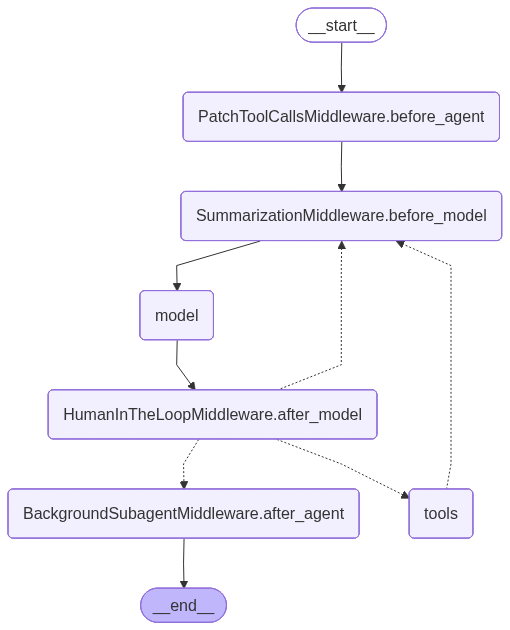

In [2]:
# Change to project root so MCP server relative paths resolve correctly
os.chdir(PROJECT_ROOT)

# Create session with Daytona sandbox
core_config = config.to_core_config()
session = SessionManager.get_session("demo-notebook", core_config)
await session.initialize()

# Create the agent via PTCAgent
ptc_agent = PTCAgent(config)
agent = ptc_agent.create_agent(
    sandbox=session.sandbox,
    mcp_registry=session.mcp_registry,
    subagent_names=["research", "general-purpose"]
)

# Show the agent graph
display(Image(agent.get_graph().draw_mermaid_png()))

In [3]:
print_agent_config(config, session, ptc_agent=ptc_agent)

AGENT CONFIGURATION SUMMARY

📦 LLM CONFIGURATION
----------------------------------------
  Name:      gpt-5.1-codex-mini
  Model ID:  gpt-5.1-codex-mini
  Provider:  openai
  Parameters: {'reasoning': {'effort': 'low', 'summary': 'auto'}}

🔌 MCP SERVERS
----------------------------------------
  tickertick: 7 tools
    ['get_ticker_news', 'get_broad_ticker_news', 'get_news_from_source', 'get_news_for_multiple_tickers', 'get_curated_news', 'get_entity_news', 'search_tickers']
  yfinance: 21 tools
    ['get_stock_history', 'get_income_statement', 'get_balance_sheet', 'get_cash_flow', 'get_options_chain', 'get_company_info', 'get_analyst_recommendations', 'get_institutional_holders', 'get_dividends_and_splits', 'get_earnings_data', 'get_earnings_dates', 'get_insider_transactions', 'get_mutualfund_holders', 'get_sustainability_data', 'get_news', 'get_insider_roster', 'get_multiple_stocks_history', 'compare_financials', 'get_multiple_stocks_dividends', 'get_multiple_stocks_earnings', 'comp

### Runtime system prompt

In [4]:
# Get the formatted tool summary from MCP registry
tool_summary = ptc_agent._get_tool_summary(session.mcp_registry)

subagent_summary = ptc_agent._get_subagent_summary()
# Build the complete system prompt
system_prompt = ptc_agent._build_system_prompt(tool_summary, subagent_summary)

# Show the complete prompt
print(f"Total prompt length: {len(system_prompt)} characters")
show_prompt(system_prompt, title="PTCAgent Runtime System Prompt", border_style="green")

Total prompt length: 15420 characters


╭──────────────────────────────────────── PTCAgent Runtime System Prompt ─────────────────────────────────────────╮
│                                                                                                                 │
│  For context, today's date is 2025-12-09.                                                                       │
│                                                                                                                 │
│  <task_workflow>                                                                                                │
│  # Task Workflow                                                                                                │
│                                                                                                                 │
│  Follow this workflow for all task requests:                                                                    │
│                                                                                                                 │
│  1. **Save the request**: Use write_file() to save the user's task description to `/results/task_request.md`    │
│  2. **Plan**: Create a todo list with write_todos to break down the task into focused steps                     │
│  3. **Execute**: Delegate subtasks to sub-agents using the task() tool, or execute directly                     │
│  4. **Write Output**: Write comprehensive results to `/results/` directory (see Output Guidelines below)        │
│  5. **Verify**: Read `/results/task_request.md` to confirm you've addressed all aspects of the original         │
│  request                                                                                                        │
│                                                                                                                 │
│  ## Task Planning Guidelines                                                                                    │
│  - Batch similar subtasks into a single TODO to minimize overhead                                               │
│  - For simple tasks, execute directly or use 1 sub-agent                                                        │
│  - For comparisons or multi-faceted tasks, delegate to multiple parallel sub-agents                             │
│  - Each sub-agent should handle one specific aspect and return findings                                         │
│  </task_workflow>                                                                                               │
│                                                                                                                 │
│  <workspace_paths>                                                                                              │
│  # Workspace Structure                                                                                          │
│                                                                                                                 │
│  Working directory: `/home/daytona`                                                                             │
│                                                                                                                 │
│  ## Standard Directories                                                                                        │
│                                                                                                                 │
│  | Directory | Purpose |                                                                                        │
│  |-----------|---------|                                                                                        │
│  | `results/` | Final deliverables (reports, visualizations) |                                                  │
│  | `data/` | Intermediate storage (tool results, API responses) |                                               │
│  | `tools/` | MCP tool modules (auto-generated) |     

### Sandbox workspace preview

In [5]:
# Display sandbox file tree BEFORE agent execution
print("=" * 50)
print("Sandbox File Tree (BEFORE)")
print("=" * 50)
print("./")
print_sandbox_tree(session.sandbox)

Sandbox File Tree (BEFORE)
./
├── code/
├── data/
├── mcp_servers/
│   ├── tickertick_mcp_server.py
│   └── yfinance_mcp_server.py
├── results/
└── tools/
    ├── docs/
    │   ├── tickertick/
    │   │   ├── get_broad_ticker_news.md
    │   │   ├── get_curated_news.md
    │   │   ├── get_entity_news.md
    │   │   ├── get_news_for_multiple_tickers.md
    │   │   ├── get_news_from_source.md
    │   │   ├── get_ticker_news.md
    │   │   └── search_tickers.md
    │   └── yfinance/
    │       ├── compare_financials.md
    │       ├── compare_valuations.md
    │       ├── get_analyst_recommendations.md
    │       ├── get_balance_sheet.md
    │       ├── get_cash_flow.md
    │       ├── get_company_info.md
    │       ├── get_dividends_and_splits.md
    │       ├── get_earnings_data.md
    │       ├── get_earnings_dates.md
    │       ├── get_income_statement.md
    │       ├── get_insider_roster.md
    │       ├── get_insider_transactions.md
    │       ├── get_institutional_holders.md


### Agent execution

In [6]:
# You may changes this to your own query.
# By default, two custom finance related mcp servers are available. 
# Make sure you configure any additional MCP servers if you want to test it outside of the default scope.
query = """compare the stock price of nvidia and amd over the past year. create a 2 by 2 chart that shows the price, volume, some key fundemental data comparison"""

In [7]:
result = await agent.ainvoke(
    {
        "messages": [
            {
                "role": "user",
                "content": query
            }
        ],
    }, 
)

format_messages(result["messages"])

2025-12-09 17:09:36 [info     ] Orchestrator invoking agent    has_messages=True iteration=1
2025-12-09 17:09:38 [info     ] Writing file                   file_path=results/task_request.md normalized_path=/home/daytona/results/task_request.md size=150
2025-12-09 17:09:38 [info     ] Wrote 150 bytes to /home/daytona/results/task_request.md
2025-12-09 17:09:38 [info     ] File written successfully      bytes_written=150 file_path=/results/task_request.md
2025-12-09 17:09:43 [info     ] Globbing files                 normalized_path=/home/daytona path= pattern=tools/docs/yfinance/*.md
2025-12-09 17:09:43 [info     ] Found 21 files matching tools/docs/yfinance/*.md
2025-12-09 17:09:43 [info     ] Glob completed successfully    matches=21 path= pattern=tools/docs/yfinance/*.md
2025-12-09 17:09:45 [info     ] Reading file                   file_path=tools/docs/yfinance/get_multiple_stocks_history.md limit=400 normalized_path=/home/daytona/tools/docs/yfinance/get_multiple_stocks_history.md o

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ compare the stock price of nvidia and amd over the past year. create a 2 by 2 chart that shows the price,       │
│ volume, some key fundemental data comparison                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "results/task_request.md",                                                                       │
│   "content": "compare the stock price of nvidia and amd over the past year. create a 2 by 2 chart that shows    │
│ the price, volume, some key fundemental data comparison"                                                        │
│ }                                                                                                               │
│    ID: call_rVffX5HNtqAy7vg84K9nOwwV                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote 150 bytes to /results/task_request.md                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Gather past year price and volume data for NVDA and AMD using yfinance",                      │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Collect key fundamental metrics for NVDA and AMD and prepare comparison data",                │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Create 2x2 chart with price, volume, and fundamental comparison and summarize findings",      │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_zwuDZZ9fJlN7qf4RAEnM5rdL                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Gather past year price and volume data for NVDA and AMD using yfinance',     │
│ 'status': 'in_progress'}, {'content': 'Collect key fundamental metrics for NVDA and AMD and prepare comparison  │
│ data', 'status': 'pending'}, {'content': 'Create 2x2 chart with price, volume, and fundamental comparison and   │
│ summarize findings', 'status': 'pending'}]                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: glob                                                                                              │
│    Args: {                                                                                                      │
│   "pattern": "tools/docs/yfinance/*.md",                                                                        │
│   "path": ""                                                                                                    │
│ }                                                                                                               │
│    ID: call_chGDYWMMnh4Ywd1UOauaxjGj                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Found 21 file(s) matching 'tools/docs/yfinance/*.md':                                                           │
│ /tools/docs/yfinance/get_multiple_stocks_earnings.md                                                            │
│ /tools/docs/yfinance/get_multiple_stocks_dividends.md                                                           │
│ /tools/docs/yfinance/compare_valuations.md                                                                      │
│ /tools/docs/yfinance/compare_financials.md                                                                      │
│ /tools/docs/yfinance/get_multiple_stocks_history.md                                                             │
│ /tools/docs/yfinance/get_earnings_dates.md                                                                      │
│ /tools/docs/yfinance/get_insider_roster.md                                                                      │
│ /tools/docs/yfinance/get_news.md                                                                                │
│ /tools/docs/yfinance/get_cash_flow.md                                                                           │
│ /tools/docs/yfinance/get_insider_transactions.md                                                                │
│ /tools/docs/yfinance/get_sustainability_data.md                                                                 │
│ /tools/docs/yfinance/get_earnings_data.md                                                                       │
│ /tools/docs/yfinance/get_mutualfund_holders.md                                                                  │
│ /tools/docs/yfinance/get_balance_sheet.md                                                                       │
│ /tools/docs/yfinance/get_dividends_and_splits.md                                                                │
│ /tools/docs/yfinance/get_stock_history.md                                                                       │
│ /tools/docs/yfinance/get_income_statement.md                                                                    │
│ /tools/docs/yfinance/get_company_info.md                                                                        │
│ /tools/docs/yfinance/get_institutional_holders.md                                                               │
│ /tools/docs/yfinance/get_analyst_recommendations.md                                                             │
│ /tools/docs/yfinance/get_options_chain.md                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "tools/docs/yfinance/get_multiple_stocks_history.md",                                            │
│   "offset": 0,                                                                                                  │
│   "limit": 400                                                                                                  │
│ }                                                                                                               │
│    ID: call_7x43Xsyx7L0Q2lKkx87I6ury                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→# get_multiple_stocks_history(tickers: List, period: str = 1y, interval: str = 1d)                       │
│      2→                                                                                                         │
│      3→                                                                                                         │
│      4→    Get historical data for multiple stocks in a single call.                                            │
│      5→                                                                                                         │
│      6→    VERY HIGH PTC VALUE: Returns N × 252 rows per year for N stocks.                                     │
│      7→    Ideal for portfolio analysis, correlation studies, and comparative performance.                      │
│      8→                                                                                                         │
│      9→    Args:                                                                                                │
│     10→        tickers: List of ticker symbols (e.g., ["AAPL", "MSFT", "GOOGL"])                                │
│     11→        period: Data period - 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max                           │
│     12→        interval: Data interval - 1d, 5d, 1wk, 1mo, 3mo                                                  │
│     13→                                                                                                         │
│     14→    Returns:                                                                                             │
│     15→        dict: {                                                                                          │
│     16→            "period": str,                                                                               │
│     17→            "interval": str,                                                                             │
│     18→            "data": {ticker: {"count": int, "history": list}},                                           │
│     19→            "successful_tickers": list,                                                                  │
│     20→            "total_data_points": int,                                                                    │
│     21→            "errors": list  # Optional, only if errors occurred                                          │
│     22→        }                                                                                                │
│     23→        Use pd.DataFrame(result["data"]["AAPL"]["history"]) to convert to DataFrame.                     │
│     24→                                                                                                         │
│     25→                                                                                                         │
│     26→## Parameters                                                                                            │
│     27→                                                                                                         │
│     28→- `tickers` (array) - **Required**                                                                       │
│     29→                                                                                                         │
│     30→- `period` (string) - Optional                                                                           │
│     31→                                                                                                         │
│     32→- `interval` (string) - Optional                                                                         │
│     33→                                                                                                         │
│     34→## Returns                                      

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "tools/docs/yfinance/compare_financials.md",                                                     │
│   "offset": 0,                                                                                                  │
│   "limit": 400                                                                                                  │
│ }                                                                                                               │
│    ID: call_tWiQGiFWDsyFhcFH4REYFFaZ                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→# compare_financials(tickers: List, statement_type: str = income, quarterly: bool = True)                │
│      2→                                                                                                         │
│      3→                                                                                                         │
│      4→    Get financial statements for multiple companies for side-by-side comparison.                         │
│      5→                                                                                                         │
│      6→    VERY HIGH PTC VALUE: Returns N companies × 4 periods × 30+ line items.                               │
│      7→    Ideal for peer comparison, sector analysis, and competitive benchmarking.                            │
│      8→                                                                                                         │
│      9→    Args:                                                                                                │
│     10→        tickers: List of ticker symbols (e.g., ["AAPL", "MSFT", "GOOGL"])                                │
│     11→        statement_type: Type of statement - "income", "balance", or "cashflow"                           │
│     12→        quarterly: If True, returns quarterly data; if False, returns annual                             │
│     13→                                                                                                         │
│     14→    Returns:                                                                                             │
│     15→        Dictionary with each ticker's financial statement: {ticker: {data}}                              │
│     16→                                                                                                         │
│     17→                                                                                                         │
│     18→## Parameters                                                                                            │
│     19→                                                                                                         │
│     20→- `tickers` (array) - **Required**                                                                       │
│     21→                                                                                                         │
│     22→- `statement_type` (string) - Optional                                                                   │
│     23→                                                                                                         │
│     24→- `quarterly` (boolean) - Optional                                                                       │
│     25→                                                                                                         │
│     26→## Returns                                                                                               │
│     27→                                                                                                         │
│     28→**Type:** `dict`                                                                                         │
│     29→                                                                                                         │
│     30→Dictionary with each ticker's financial statement: {ticker: {data}}                                      │
│     31→                                                                                                         │
│     32→## Example                                                                                               │
│     33→                                                                                                         │
│     34→```python                                       

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "tools/docs/yfinance/compare_valuations.md",                                                     │
│   "offset": 0,                                                                                                  │
│   "limit": 400                                                                                                  │
│ }                                                                                                               │
│    ID: call_PKIaxy2llThROkks9lBEAcnc                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→# compare_valuations(tickers: List)                                                                      │
│      2→                                                                                                         │
│      3→                                                                                                         │
│      4→    Compare valuation metrics (P/E, P/B, dividend yield, etc.) across multiple stocks.                   │
│      5→                                                                                                         │
│      6→    VERY HIGH PTC VALUE: Returns valuation multiples for N stocks.                                       │
│      7→    Ideal for relative valuation analysis, value screening, and peer comparison.                         │
│      8→                                                                                                         │
│      9→    Args:                                                                                                │
│     10→        tickers: List of ticker symbols (e.g., ["AAPL", "MSFT", "GOOGL"])                                │
│     11→                                                                                                         │
│     12→    Returns:                                                                                             │
│     13→        dict: {                                                                                          │
│     14→            "data": {ticker: {pe_ratio, pb_ratio, dividend_yield, market_cap, ...}},                     │
│     15→            "successful_tickers": list,                                                                  │
│     16→            "errors": list  # Optional                                                                   │
│     17→        }                                                                                                │
│     18→                                                                                                         │
│     19→                                                                                                         │
│     20→## Parameters                                                                                            │
│     21→                                                                                                         │
│     22→- `tickers` (array) - **Required**                                                                       │
│     23→                                                                                                         │
│     24→## Returns                                                                                               │
│     25→                                                                                                         │
│     26→**Type:** `dict`                                                                                         │
│     27→                                                                                                         │
│     28→dict: {                                                                                                  │
│     29→            "data": {ticker: {pe_ratio, pb_ratio, dividend_yield, market_cap, ...}},                     │
│     30→            "successful_tickers": list,                                                                  │
│     31→            "errors": list  # Optional                                                                   │
│     32→        }                                                                                                │
│     33→                                                                                                         │
│     34→## Example                                      

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "from tools.yfinance import get_multiple_stocks_history\nimport json\n\nresult =                      │
│ get_multiple_stocks_history(tickers=[\"NVDA\", \"AMD\"], period=\"1y\", interval=\"1d\")\nwith                  │
│ open('data/stock_history_nvda_amd.json', 'w') as f:\n    json.dump(result, f, indent=2)\nprint('Data saved to   │
│ data/stock_history_nvda_amd.json')"                                                                             │
│ }                                                                                                               │
│    ID: call_V0IA9RBpEC6K19xmQgvas9Au                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ Data saved to data/stock_history_nvda_amd.json                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "from tools.yfinance import compare_valuations\nimport json\n\nresult =                               │
│ compare_valuations(tickers=[\"NVDA\", \"AMD\"])\nwith open('data/valuation_comparison_nvda_amd.json', 'w') as   │
│ f:\n    json.dump(result, f, indent=2)\nprint('Valuation data saved to                                          │
│ data/valuation_comparison_nvda_amd.json')"                                                                      │
│ }                                                                                                               │
│    ID: call_UvHJYGIHo6dJmFobU9B2FTxU                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ Valuation data saved to data/valuation_comparison_nvda_amd.json                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "from tools.yfinance import compare_financials\nimport json\n\nresult =                               │
│ compare_financials(tickers=[\"NVDA\", \"AMD\"], statement_type=\"income\", quarterly=False)\nwith               │
│ open('data/financials_nvda_amd.json', 'w') as f:\n    json.dump(result, f, indent=2)\nprint('Financials saved   │
│ to data/financials_nvda_amd.json')"                                                                             │
│ }                                                                                                               │
│    ID: call_KNRr5BhfbDThoDTGnRk1zZg8                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ Financials saved to data/financials_nvda_amd.json                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import pandas as pd\nimport json\nfrom pathlib import Path\n\nwith                                   │
│ open('data/stock_history_nvda_amd.json') as f:\n    history = json.load(f)\n\ndata = {}\nfor ticker, info in    │
│ history['data'].items():\n    df = pd.DataFrame(info['history'])\n    df['date'] = pd.to_datetime(df['date'])\n │
│ df.sort_values('date', inplace=True)\n    data = df\n\nprint('NVDA rows', len(data['NVDA']))\nprint('AMD rows', │
│ len(data['AMD']))\nprint(data['NVDA'].head())"                                                                  │
│ }                                                                                                               │
│    ID: call_ta8Hp45JQohu53BLcvEot9qt                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ERROR                                                                                                           │
│ Failed to upload files: [Errno 54] Connection reset by peer                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import pandas as pd\nimport json\n\nwith open('data/stock_history_nvda_amd.json') as f:\n    history │
│ = json.load(f)\n\ndata = {}\nfor ticker, info in history['data'].items():\n    df =                             │
│ pd.DataFrame(info['history'])\n    df['date'] = pd.to_datetime(df['date'])\n    df.sort_values('date',          │
│ inplace=True)\n    data = df\n\nprint('NVDA rows', len(data['NVDA']))\nprint('AMD rows',                        │
│ len(data['AMD']))\nprint(data['NVDA'].head())"                                                                  │
│ }                                                                                                               │
│    ID: call_F9vp9avOUFVgUhL2dmBpi7ky                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ NVDA rows 250                                                                                                   │
│ AMD rows 250                                                                                                    │
│         date    open    high     low   close     volume  dividends  splits                                      │
│ 0 2024-12-10  138.97  141.78  133.75  135.03  210020900        0.0     0.0                                      │
│ 1 2024-12-11  137.32  140.13  135.17  139.27  184905200        0.0     0.0                                      │
│ 2 2024-12-12  137.04  138.40  135.76  137.30  159211400        0.0     0.0                                      │
│ 3 2024-12-13  138.90  139.56  132.50  134.21  231514900        0.0     0.0                                      │
│ 4 2024-12-16  134.14  134.36  130.38  131.96  237951100        0.0     0.0                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\nfrom pprint import pprint\n\nwith open('data/valuation_comparison_nvda_amd.json') as    │
│ f:\n    valuations = json.load(f)\n\npprint(valuations['data'])\n"                                              │
│ }                                                                                                               │
│    ID: call_3IDYP6VbC0gvGNb95Rztp6AQ                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ {'AMD': {'beta': 1.927,                                                                                         │
│          'current_price': 221.62,                                                                               │
│          'dividend_yield': None,                                                                                │
│          'enterprise_to_ebitda': 58.059,                                                                        │
│          'enterprise_to_revenue': 10.975,                                                                       │
│          'enterprise_value': 351491227648,                                                                      │
│          'fifty_day_average': 225.7556,                                                                         │
│          'fifty_two_week_high': 267.08,                                                                         │
│          'fifty_two_week_low': 76.48,                                                                           │
│          'forward_p_e': 43.454903,                                                                              │
│          'market_cap': 360806580224,                                                                            │
│          'payout_ratio': 0.0,                                                                                   │
│          'peg_ratio': None,                                                                                     │
│          'price_to_book': 5.93519,                                                                              │
│          'price_to_sales_trailing12_months': 11.2657,                                                           │
│          'trailing_p_e': 115.427086,                                                                            │
│          'two_hundred_day_average': 153.6561},                                                                  │
│  'NVDA': {'beta': 2.284,                                                                                        │
│           'current_price': 184.97,                                                                              │
│           'dividend_yield': 0.02,                                                                               │
│           'enterprise_to_ebitda': 38.89,                                                                        │
│           'enterprise_to_revenue': 23.42,                                                                       │
│           'enterprise_value': 4382776885248,                                                                    │
│           'fifty_day_average': 187.2448,                                                                        │
│           'fifty_two_week_high': 212.19,                                                                        │
│           'fifty_two_week_low': 86.62,                                                                          │
│           'forward_p_e': 44.895634,                                                                             │
│           'market_cap': 4503464574976,                                                                          │
│           'payout_ratio': 0.0099,                                                                               │
│           'peg_ratio': None,                                                                                    │
│           'price_to_book': 37.81071,                                                                            │
│           'price_to_sales_trailing12_months': 24.064425,                                                        │
│           'trailing_p_e': 45.898262,                   

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\n\nwith open('data/financials_nvda_amd.json') as f:\n    financials =                    │
│ json.load(f)\n\nfor ticker, data in financials.items():\n    print(ticker, 'quarters', len(data['data']))\n     │
│ print(data['data'][0])"                                                                                         │
│ }                                                                                                               │
│    ID: call_yCYl1cHaos2jaMippqnUHHd6                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ERROR                                                                                                           │
│ Traceback (most recent call last):                                                                              │
│   File "<string>", line 1, in <module>                                                                          │
│   File "<string>", line 7, in <module>                                                                          │
│ TypeError: string indices must be integers, not 'str'                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\n\nwith open('data/financials_nvda_amd.json') as f:\n    data =                          │
│ json.load(f)\n\nprint(data.keys())"                                                                             │
│ }                                                                                                               │
│    ID: call_sycGF5WJf8UlcOTCB0edmhWv                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ dict_keys(['statement_type', 'quarterly', 'data', 'successful_tickers'])                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\n\nwith open('data/financials_nvda_amd.json') as f:\n    data =                          │
│ json.load(f)\n\nprint(data['statement_type'], data['quarterly'])\nfor ticker, statements in                     │
│ data['data'].items():\n    print(ticker)\n    for entry in statements[:1]:\n        print(entry)\n              │
│ break"                                                                                                          │
│ }                                                                                                               │
│    ID: call_290kXskYCPYk5NjyU1CNCjpk                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ERROR                                                                                                           │
│ income False                                                                                                    │
│ NVDA                                                                                                            │
│ Traceback (most recent call last):                                                                              │
│   File "<string>", line 1, in <module>                                                                          │
│   File "<string>", line 9, in <module>                                                                          │
│ KeyError: slice(None, 1, None)                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\n\nwith open('data/financials_nvda_amd.json') as f:\n    data = json.load(f)\n\nfor      │
│ ticker, statements in data['data'].items():\n    print(ticker, type(statements))\n                              │
│ print(list(statements.keys())[:5])\n    break"                                                                  │
│ }                                                                                                               │
│    ID: call_AdodOsLP4bP6uLIBLu2wnrHA                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ NVDA <class 'dict'>                                                                                             │
│ ['Tax Effect Of Unusual Items', 'Tax Rate For Calcs', 'Normalized EBITDA', 'Total Unusual Items', 'Total        │
│ Unusual Items Excluding Goodwill']                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\nfrom itertools import islice\n\nwith open('data/financials_nvda_amd.json') as f:\n      │
│ data = json.load(f)\n\nfor ticker, statements in data['data'].items():\n    print(ticker)\n    for key, value   │
│ in list(statements.items())[:5]:\n        print(key, type(value))\n    break"                                   │
│ }                                                                                                               │
│    ID: call_iEp4SsqFydWUGpGZZiNI2ooU                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ NVDA                                                                                                            │
│ Tax Effect Of Unusual Items <class 'dict'>                                                                      │
│ Tax Rate For Calcs <class 'dict'>                                                                               │
│ Normalized EBITDA <class 'dict'>                                                                                │
│ Total Unusual Items <class 'dict'>                                                                              │
│ Total Unusual Items Excluding Goodwill <class 'dict'>                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\n\nwith open('data/financials_nvda_amd.json') as f:\n    data = json.load(f)\n\nmetric = │
│ data['data']['NVDA']['Total Revenue']\nprint(type(metric))\nprint(metric.keys())\nprint(metric['2024-04-30'])"  │
│ }                                                                                                               │
│    ID: call_iKaTNgZdjqOSlLik2YYM2GxV                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ERROR                                                                                                           │
│ <class 'dict'>                                                                                                  │
│ dict_keys(['2025-01-31', '2024-01-31', '2023-01-31', '2022-01-31'])                                             │
│ Traceback (most recent call last):                                                                              │
│   File "<string>", line 1, in <module>                                                                          │
│   File "<string>", line 9, in <module>                                                                          │
│ KeyError: '2024-04-30'                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\n\nwith open('data/financials_nvda_amd.json') as f:\n    data = json.load(f)\n\nmetrics  │
│ = ['Total Revenue', 'Net Income', 'Operating Income', 'Earnings Before Tax']\nsummary = {}\nfor ticker,         │
│ statements in data['data'].items():\n    summary = {}\n    for metric in metrics:\n        values =             │
│ statements.get(metric, {})\n        if values:\n            latest_period = max(values.keys())\n                │
│ summary = {\n                'period': latest_period,\n                'value': values\n            }\n         │
│ else:\n            summary = None\n\nprint(summary)\n"                                                          │
│ }                                                                                                               │
│    ID: call_rmZDfiFGvGlCXjNKwkF1nrig                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ {'NVDA': {'Total Revenue': {'period': '2025-01-31', 'value': 130497000000.0}, 'Net Income': {'period':          │
│ '2025-01-31', 'value': 72880000000.0}, 'Operating Income': {'period': '2025-01-31', 'value': 81453000000.0},    │
│ 'Earnings Before Tax': None}, 'AMD': {'Total Revenue': {'period': '2024-12-31', 'value': 25785000000.0}, 'Net   │
│ Income': {'period': '2024-12-31', 'value': 1641000000.0}, 'Operating Income': {'period': '2024-12-31', 'value': │
│ 2086000000.0}, 'Earnings Before Tax': None}}                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import pandas as pd\nimport json\nimport matplotlib.pyplot as plt\nfrom matplotlib.ticker import     │
│ FuncFormatter\n\nwith open('data/stock_history_nvda_amd.json') as f:\n    history = json.load(f)\n\ndata =      │
│ {}\nfor ticker, info in history['data'].items():\n    df = pd.DataFrame(info['history'])\n    df['date'] =      │
│ pd.to_datetime(df['date'])\n    df.sort_values('date', inplace=True)\n    df.reset_index(drop=True,             │
│ inplace=True)\n    data = df\n\nwith open('data/valuation_comparison_nvda_amd.json') as f:\n    valuations =    │
│ json.load(f)['data']\n\nwith open('data/financials_nvda_amd.json') as f:\n    financials = json.load(f)\n\n#    │
│ Summary metrics for text\nsummary = {}\nfor ticker in data:\n    df = data\n    start = df['close'].iloc[0]\n   │
│ end = df['close'].iloc[-1]\n    change_pct = (end - start)/start * 100\n    avg_volume = df['volume'].mean()\n  │
│ summary = {\n        'start_close': start,\n        'end_close': end,\n        'change_pct': change_pct,\n      │
│ 'avg_volume': avg_volume,\n        'market_cap': valuations['market_cap'],\n        'trailing_pe':              │
│ valuations['trailing_p_e'],\n        'forward_pe': valuations['forward_p_e'],\n        'price_to_sales':        │
│ valuations['price_to_sales_trailing12_months'],\n        'price_to_book': valuations['price_to_book'],\n        │
│ 'revenue': financials['data']['Total Revenue'],\n        'net_income': financials['data']['Net Income'],\n      │
│ }\n\n# Plotting\nfig, axes = plt.subplots(2, 2, figsize=(16, 12))\nprice_ax = axes[0,0]\nvolume_ax =            │
│ axes[0,1]\nvaluation_ax = axes[1,0]\nincome_ax = axes[1,1]\n\n# Price chart\nfor ticker, df in data.items():\n  │
│ price_ax.plot(df['date'], df['close'], label=ticker)\nprice_ax.set_title('Daily Close Price (Past               │
│ Year)')\nprice_ax.set_ylabel('Price (USD)')\nprice_ax.legend()\nprice_ax.grid(True)\n\n# Volume chart (30-day   │
│ rolling avg)\nfor ticker, df in data.items():\n    volume_ax.plot(df['date'], df['volume'].rolling(window=20,   │
│ min_periods=1).mean()/1e6, label=ticker)\nvolume_ax.set_title('20-Day Average                                   │
│ Volume')\nvolume_ax.set_ylabel('Volume (Millions of Shares)')\nvolume_ax.legend()\nvolume_ax.grid(True)\n\n#    │
│ Valuation chart (grouped bars for trailing PE, forward PE, price-to-sales, price-to-book)\nmetrics =            │
│ ['trailing_p_e', 'forward_p_e', 'price_to_sales', 'price_to_book']\nlabels = ['Trailing P/E', 'Forward P/E',    │
│ 'Price/Sales', 'Price/Book']\nx = range(len(metrics))\nwidth = 0.35\nvaluation_ax.bar(, [summary['NVDA'] for m  │
│ in metrics], width, label='NVDA')\nvaluation_ax.bar(, [summary['AMD'] for m in metrics], width,                 │
│ label='AMD')\nvaluation_ax.set_title('Valuation Metrics                                                         │
│ Comparison')\nvaluation_ax.set_xticks(x)\nvaluation_ax.set_xticklabels(labels)\nvaluation_ax.legend()\nvaluatio │
│ n_ax.grid(True, axis='y')\n\n# Income chart (Total Revenue & Net Income in billions)\nincome_labels =           │
│ ['Revenue', 'Net Income']\nnvda_vals =                                                                          │
│ [summary['NVDA']['revenue'][max(summary['NVDA']['revenue'].keys())]/1e9,\n                                      │
│ summary['NVDA']['net_income'][max(summary['NVDA']['net_income'].keys())]/1e9]\namd_vals =                       │
│ [summary['AMD']['revenue'][max(summary['AMD']['revenue']

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ERROR                                                                                                           │
│ Traceback (most recent call last):                                                                              │
│   File "<target_code>", line 73, in <module>                                                                    │
│     valuation_ax.bar(, [summary['NVDA'] for m in metrics], width, label='NVDA')                                 │
│                                                  ~~~~~~~~~~~~~~~^^^                                             │
│ KeyError: 'trailing_p_e'                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import pandas as pd\nimport json\nimport matplotlib.pyplot as plt\n\nwith                            │
│ open('data/stock_history_nvda_amd.json') as f:\n    history = json.load(f)\n\ndata = {}\nfor ticker, info in    │
│ history['data'].items():\n    df = pd.DataFrame(info['history'])\n    df['date'] = pd.to_datetime(df['date'])\n │
│ df.sort_values('date', inplace=True)\n    df.reset_index(drop=True, inplace=True)\n    data = df\n\nwith        │
│ open('data/valuation_comparison_nvda_amd.json') as f:\n    valuations = json.load(f)['data']\n\nwith            │
│ open('data/financials_nvda_amd.json') as f:\n    financials = json.load(f)\n\nsummary = {}\nfor ticker in       │
│ data:\n    df = data\n    start = df['close'].iloc[0]\n    end = df['close'].iloc[-1]\n    change_pct = (end -  │
│ start)/start * 100\n    avg_volume = df['volume'].mean()\n    latest_revenue_key =                              │
│ max(financials['data']['Total Revenue'].keys())\n    latest_net_income_key = max(financials['data']['Net        │
│ Income'].keys())\n    summary = {\n        'change_pct': change_pct,\n        'avg_volume': avg_volume,\n       │
│ 'market_cap': valuations['market_cap'],\n        'trailing_pe': valuations['trailing_p_e'],\n                   │
│ 'forward_pe': valuations['forward_p_e'],\n        'price_to_sales':                                             │
│ valuations['price_to_sales_trailing12_months'],\n        'price_to_book': valuations['price_to_book'],\n        │
│ 'revenue': financials['data']['Total Revenue'],\n        'net_income': financials['data']['Net Income'],\n      │
│ 'revenue_period': latest_revenue_key,\n        'net_income_period': latest_net_income_key,\n    }\n\nfig, axes  │
│ = plt.subplots(2, 2, figsize=(16, 12))\nprice_ax = axes[0,0]\nvolume_ax = axes[0,1]\nvaluation_ax =             │
│ axes[1,0]\nincome_ax = axes[1,1]\n\n# Price chart\nfor ticker, df in data.items():\n                            │
│ price_ax.plot(df['date'], df['close'], label=ticker)\nprice_ax.set_title('Daily Close Price (Past               │
│ Year)')\nprice_ax.set_ylabel('Price (USD)')\nprice_ax.legend()\nprice_ax.grid(True)\n\n# Volume chart\nfor      │
│ ticker, df in data.items():\n    volume_ax.plot(df['date'], df['volume'].rolling(window=20,                     │
│ min_periods=1).mean()/1e6, label=ticker)\nvolume_ax.set_title('20-Day Average                                   │
│ Volume')\nvolume_ax.set_ylabel('Volume (Millions of Shares)')\nvolume_ax.legend()\nvolume_ax.grid(True)\n\n#    │
│ Valuation chart\nmetrics = ['trailing_pe', 'forward_pe', 'price_to_sales', 'price_to_book']\nlabels =           │
│ ['Trailing P/E', 'Forward P/E', 'Price/Sales', 'Price/Book']\nx = range(len(metrics))\nwidth =                  │
│ 0.35\nvaluation_ax.bar(, [summary['NVDA'] if summary['NVDA'] is not None else 0 for m in metrics], width,       │
│ label='NVDA')\nvaluation_ax.bar(, [summary['AMD'] if summary['AMD'] is not None else 0 for m in metrics],       │
│ width, label='AMD')\nvaluation_ax.set_title('Valuation Metrics                                                  │
│ Comparison')\nvaluation_ax.set_xticks(x)\nvaluation_ax.set_xticklabels(labels)\nvaluation_ax.legend()\nvaluatio │
│ n_ax.grid(True, axis='y')\n\n# Income chart\nincome_labels = ['Revenue', 'Net Income']\nnvda_vals =             │
│ [summary['NVDA']['revenue']/1e9, summary['NVDA']['net_income']/1e9]\namd_vals = [summary['AMD']['revenue']/1e9, │
│ summary['AMD']['net_income']/1e9]\nincs = range(len(inco

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ERROR                                                                                                           │
│ Traceback (most recent call last):                                                                              │
│   File "<target_code>", line 85, in <module>                                                                    │
│     income_ax.bar(, nvda_vals, width, label='NVDA')                                                             │
│                                          ^^^^                                                                   │
│ NameError: name 'niks' is not defined                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import pandas as pd\nimport json\nimport matplotlib.pyplot as plt\n\nwith                            │
│ open('data/stock_history_nvda_amd.json') as f:\n    history = json.load(f)\n\ndata = {}\nfor ticker, info in    │
│ history['data'].items():\n    df = pd.DataFrame(info['history'])\n    df['date'] = pd.to_datetime(df['date'])\n │
│ df.sort_values('date', inplace=True)\n    df.reset_index(drop=True, inplace=True)\n    data = df\n\nwith        │
│ open('data/valuation_comparison_nvda_amd.json') as f:\n    valuations = json.load(f)['data']\n\nwith            │
│ open('data/financials_nvda_amd.json') as f:\n    financials = json.load(f)\n\nsummary = {}\nfor ticker in       │
│ data:\n    df = data\n    start = df['close'].iloc[0]\n    end = df['close'].iloc[-1]\n    change_pct = (end -  │
│ start)/start * 100\n    avg_volume = df['volume'].mean()\n    latest_revenue_key =                              │
│ max(financials['data']['Total Revenue'].keys())\n    latest_net_income_key = max(financials['data']['Net        │
│ Income'].keys())\n    summary = {\n        'change_pct': change_pct,\n        'avg_volume': avg_volume,\n       │
│ 'market_cap': valuations['market_cap'],\n        'trailing_pe': valuations['trailing_p_e'],\n                   │
│ 'forward_pe': valuations['forward_p_e'],\n        'price_to_sales':                                             │
│ valuations['price_to_sales_trailing12_months'],\n        'price_to_book': valuations['price_to_book'],\n        │
│ 'revenue': financials['data']['Total Revenue'],\n        'net_income': financials['data']['Net Income'],\n      │
│ 'revenue_period': latest_revenue_key,\n        'net_income_period': latest_net_income_key,\n                    │
│ 'start_close': start,\n        'end_close': end\n    }\n\nfig, axes = plt.subplots(2, 2, figsize=(16,           │
│ 12))\nprice_ax = axes[0,0]\nvolume_ax = axes[0,1]\nvaluation_ax = axes[1,0]\nincome_ax = axes[1,1]\n\n#         │
│ Price\nfor ticker, df in data.items():\n    price_ax.plot(df['date'], df['close'],                              │
│ label=ticker)\nprice_ax.set_title('Daily Close Price (Past Year)')\nprice_ax.set_ylabel('Price                  │
│ (USD)')\nprice_ax.legend()\nprice_ax.grid(True)\n\n# Volume\nfor ticker, df in data.items():\n                  │
│ volume_ax.plot(df['date'], df['volume'].rolling(window=20, min_periods=1).mean()/1e6,                           │
│ label=ticker)\nvolume_ax.set_title('20-Day Average Volume')\nvolume_ax.set_ylabel('Volume (Millions of          │
│ Shares)')\nvolume_ax.legend()\nvolume_ax.grid(True)\n\n# Valuation\nmetrics = ['trailing_pe', 'forward_pe',     │
│ 'price_to_sales', 'price_to_book']\nlabels = ['Trailing P/E', 'Forward P/E', 'Price/Sales', 'Price/Book']\nx =  │
│ range(len(metrics))\nwidth = 0.35\nvaluation_ax.bar(, [summary['NVDA'] if summary['NVDA'] is not None else 0    │
│ for m in metrics], width, label='NVDA')\nvaluation_ax.bar(, [summary['AMD'] if summary['AMD'] is not None else  │
│ 0 for m in metrics], width, label='AMD')\nvaluation_ax.set_title('Valuation Metrics                             │
│ Comparison')\nvaluation_ax.set_xticks(x)\nvaluation_ax.set_xticklabels(labels)\nvaluation_ax.legend()\nvaluatio │
│ n_ax.grid(True, axis='y')\n\n# Income\nincome_labels = ['Revenue', 'Net Income']\nvals_nvda =                   │
│ [summary['NVDA']['revenue']/1e9, summary['NVDA']['net_income']/1e9]\nvals_amd = [summary['AMD']['revenue']/1e9, │
│ summary['AMD']['net_income']/1e9]\nbars = range(len(inco

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ Chart saved and summary recorded.                                                                               │
│ Files created: results/nvda_amd_comparison.png, results/nvda_amd_summary.json                                   │
│                                                                                                                 │
│ Uploaded images:                                                                                                │
│ !(https://zexi-dev.s3.us-east-1.amazonaws.com/charts/exec_0016/nvda_amd_comparison.png)                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "results/nvda_amd_summary.json",                                                                 │
│   "offset": 0,                                                                                                  │
│   "limit": 400                                                                                                  │
│ }                                                                                                               │
│    ID: call_7r9f2l4JzrrvPselwuSIfjfg                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→{                                                                                                        │
│      2→  "NVDA": {                                                                                              │
│      3→    "change_pct": 36.984373842849735,                                                                    │
│      4→    "avg_volume": 222879494.82,                                                                          │
│      5→    "market_cap": 4503464574976,                                                                         │
│      6→    "trailing_pe": 45.898262,                                                                            │
│      7→    "forward_pe": 44.895634,                                                                             │
│      8→    "price_to_sales": 24.064425,                                                                         │
│      9→    "price_to_book": 37.81071,                                                                           │
│     10→    "revenue": 130497000000.0,                                                                           │
│     11→    "net_income": 72880000000.0,                                                                         │
│     12→    "revenue_period": "2025-01-31",                                                                      │
│     13→    "net_income_period": "2025-01-31",                                                                   │
│     14→    "start_close": 135.03,                                                                               │
│     15→    "end_close": 184.97                                                                                  │
│     16→  },                                                                                                     │
│     17→  "AMD": {                                                                                               │
│     18→    "change_pct": 73.49303272271803,                                                                     │
│     19→    "avg_volume": 49067389.896,                                                                          │
│     20→    "market_cap": 360806580224,                                                                          │
│     21→    "trailing_pe": 115.427086,                                                                           │
│     22→    "forward_pe": 43.454903,                                                                             │
│     23→    "price_to_sales": 11.2657,                                                                           │
│     24→    "price_to_book": 5.93519,                                                                            │
│     25→    "revenue": 25785000000.0,                                                                            │
│     26→    "net_income": 1641000000.0,                                                                          │
│     27→    "revenue_period": "2024-12-31",                                                                      │
│     28→    "net_income_period": "2024-12-31",                                                                   │
│     29→    "start_close": 127.74,                                                                               │
│     30→    "end_close": 221.62                                                                                  │
│     31→  }                                                                                                      │
│     32→}                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Gather past year price and volume data for NVDA and AMD using yfinance",                      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Collect key fundamental metrics for NVDA and AMD and prepare comparison data",                │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Create 2x2 chart with price, volume, and fundamental comparison and summarize findings",      │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_q4smwFBGNH7s2wzWyAwe0tjX                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Gather past year price and volume data for NVDA and AMD using yfinance',     │
│ 'status': 'completed'}, {'content': 'Collect key fundamental metrics for NVDA and AMD and prepare comparison    │
│ data', 'status': 'completed'}, {'content': 'Create 2x2 chart with price, volume, and fundamental comparison and │
│ summarize findings', 'status': 'completed'}]                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "results/task_request.md",                                                                       │
│   "offset": 0,                                                                                                  │
│   "limit": 400                                                                                                  │
│ }                                                                                                               │
│    ID: call_UwcYt0eEJbFR84QUaXfTLd9T                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→compare the stock price of nvidia and amd over the past year. create a 2 by 2 chart that shows the       │
│ price, volume, some key fundemental data comparison                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "results/nvda_amd_comparison.md",                                                                │
│   "content": "## Overview\nThe past twelve months have been positive for both NVIDIA and AMD, with each stock   │
│ recovering strongly amid sustained demand for generative AI hardware and data-center acceleration. NVIDIA ended │
│ the period with a price gain of almost 37% while AMD rallied roughly 73%, reflecting differing starting points  │
│ and the market\u2019s relative rotation between chips for AI training and broader PC graphics cycles [1][2].    │
│ The accompanying chart distills price, volume, and valuation information to highlight where the companies       │
│ converge and diverge.\n\n## Price and Volume Trends\nNVIDIA started the year near $135 and finished at about    │
│ $185, while AMD moved from roughly $128 to $222, giving NVIDIA a more gradual ascent and AMD a steeper          │
│ percentage rebound. Average daily volume for NVDA ran near 223 million shares versus approximately 49 million   │
│ for AMD, underscoring NVDA\u2019s larger float and greater liquidity. See the price line-overlays and 20-day    │
│ average volume curves in the 2\u00d72 chart for the full trajectory over the last year. ![NVDA vs AMD           │
│ comparison](https://zexi-dev.s3.us-east-1.amazonaws.com/charts/exec_0016/nvda_amd_comparison.png) [1][2]\n\n##  │
│ Fundamental Comparison\nValuation metrics highlight NVDA\u2019s premium multiples: trailing and forward P/E     │
│ ratios sit in the mid-40s while AMD\u2019s trailing P/E exceeds 115 and forward P/E is near 43. NVDA also       │
│ trades at far richer price-to-sales (\u224824\u00d7) and price-to-book (\u224838\u00d7) multiples than          │
│ AMD\u2019s roughly 11\u00d7 and 6\u00d7 figures, reflecting investor expectations for continued revenue growth. │
│ The income statement snapshot in the chart shows NVIDIA delivering approximately $130.5 billion in annual       │
│ revenue and $72.9 billion in net income (calendar 2025), versus AMD\u2019s revenue of about $25.8 billion and   │
│ $1.64 billion in net income (calendar 2024), illustrating the magnitude gap in scale despite AMD\u2019s faster  │
│ percentage price appreciation [1][2].\n\n## Conclusion\nNVIDIA remains the larger, more liquid name with        │
│ premium valuation multiples supported by vastly greater revenue and profitability, while AMD\u2019s stronger    │
│ one-year price growth and lower multiples suggest the market is still pricing in a catch-up story. The 2\u00d72 │
│ visual summary captures these contrasts across price action, volume, valuation, and income metrics so the two   │
│ stocks can be compared side by side.\n\n### Sources\n[1] NVIDIA Corporation (NVDA) Quote -                      │
│ https://finance.yahoo.com/quote/NVDA\n[2] Advanced Micro Devices, Inc. (AMD) Quote -                            │
│ https://finance.yahoo.com/quote/AMD"                                                                            │
│ }                                                                                                               │
│    ID: call_ZCBvie0EemgwwnqS5p2mfGYc                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote 2513 bytes to /results/nvda_amd_comparison.md                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ### Summary                                                                                                     │
│ - Gathered one-year daily price and volume history for NVDA and AMD via the yfinance API, then saved the raw    │
│ data for reuse and analysis.                                                                                    │
│ - Retrieved comparable valuation multiples and the latest annual income figures for both companies to           │
│ contextualize the price moves.                                                                                  │
│ - Produced a 2×2 visualization (price, volume, valuation metrics, and revenue/net income) saved as              │
│ `results/nvda_amd_comparison.png` and documented the findings in `results/nvda_amd_comparison.md`. The markdown │
│ report includes inline citations to the corresponding Yahoo Finance pages for NVDA and AMD.                     │
│                                                                                                                 │
│ ### Deliverables                                                                                                │
│ - `results/nvda_amd_comparison.png`: Four-panel chart showing price, volume, valuation metrics, and income      │
│ comparisons.                                                                                                    │
│ - `results/nvda_amd_comparison.md`: Written summary structured per the output guidelines with accompanying      │
│ citations.                                                                                                      │
│                                                                                                                 │
│ Let me know if you’d like further detail on any of the metrics or an expanded set of comparisons.               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [8]:
# Display sandbox file tree AFTER agent execution
print("=" * 50)
print("Sandbox File Tree (AFTER)")
print("=" * 50)
print("./")
print_sandbox_tree(session.sandbox)

Sandbox File Tree (AFTER)
./
├── code/
│   ├── exec_0001.py
│   ├── exec_0002.py
│   ├── exec_0003.py
│   ├── exec_0005.py
│   ├── exec_0006.py
│   ├── exec_0007.py
│   ├── exec_0008.py
│   ├── exec_0009.py
│   ├── exec_0010.py
│   ├── exec_0011.py
│   ├── exec_0012.py
│   ├── exec_0013.py
│   ├── exec_0014.py
│   ├── exec_0015.py
│   └── exec_0016.py
├── data/
│   ├── financials_nvda_amd.json
│   ├── stock_history_nvda_amd.json
│   └── valuation_comparison_nvda_amd.json
├── mcp_servers/
│   ├── tickertick_mcp_server.py
│   └── yfinance_mcp_server.py
├── results/
│   ├── nvda_amd_comparison.md
│   ├── nvda_amd_comparison.png
│   ├── nvda_amd_summary.json
│   └── task_request.md
└── tools/
    ├── __pycache__/
    │   ├── __init__.cpython-312.pyc
    │   ├── mcp_client.cpython-312.pyc
    │   └── yfinance.cpython-312.pyc
    ├── docs/
    │   ├── tickertick/
    │   │   ├── get_broad_ticker_news.md
    │   │   ├── get_curated_news.md
    │   │   ├── get_entity_news.md
    │   │   ├── ge

📊 results/nvda_amd_comparison.png


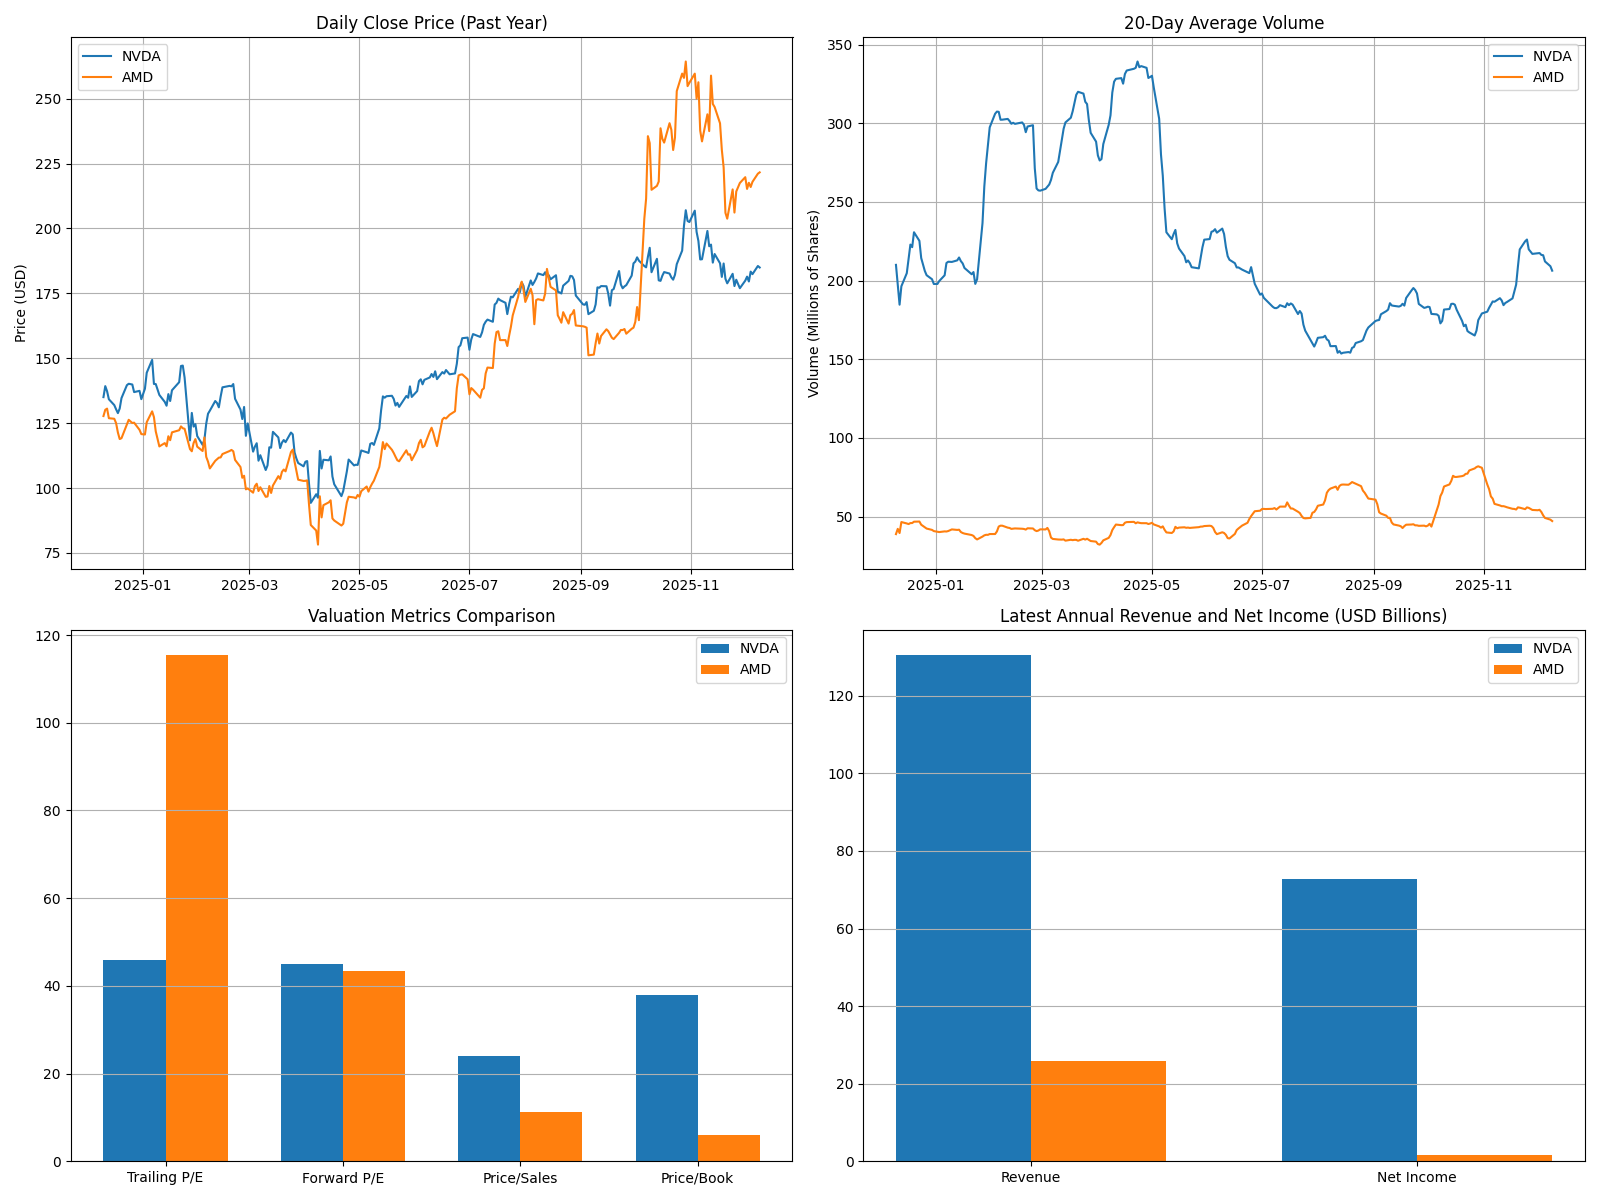


✅ Displayed 1 image(s)


In [9]:
# Display any images generated by the agent
display_sandbox_images(session.sandbox, "results")

In [10]:
# Display code file generated by agent
print("./")
print_sandbox_tree(session.sandbox, path="code/")

./
├── exec_0001.py
├── exec_0002.py
├── exec_0003.py
├── exec_0005.py
├── exec_0006.py
├── exec_0007.py
├── exec_0008.py
├── exec_0009.py
├── exec_0010.py
├── exec_0011.py
├── exec_0012.py
├── exec_0013.py
├── exec_0014.py
├── exec_0015.py
└── exec_0016.py


In [11]:
# Display results generated by agent
print("./")
print_sandbox_tree(session.sandbox, path="results/")

./
├── nvda_amd_comparison.md
├── nvda_amd_comparison.png
├── nvda_amd_summary.json
└── task_request.md


### Export Sandbox Files

Export all files from the sandbox to your local filesystem for inspection or archival.

In [12]:
# Export all sandbox files to local filesystem
# This downloads code/, data/, and results/ directories with timestamp organization
export_result = export_sandbox_files(session.sandbox)

# Dump agent messages to the same output directory for debugging
if export_result.success:
    messages_path = dump_messages(result["messages"], export_result.output_directory)
    print(f"Messages saved to: {messages_path}")

# Display the summary
print(export_result.summary())

📂 Discovering files in 'code'...
   Found 15 file(s)
📂 Discovering files in 'data'...
   Found 3 file(s)
📂 Discovering files in 'results'...
   Found 4 file(s)

✅ Export completed successfully!
   Exported 22 file(s) to: output/20251209_171152
Messages saved to: /Users/chen/projects/open-ptc-agent-feature/output/20251209_171152/messages.json

Export Summary (20251209_171152)
Output Directory: /Users/chen/projects/open-ptc-agent-feature/output/20251209_171152
Total Files: 22
Successfully Exported: 22
Failed: 0
Total Size: 299.31 KB

Directories Processed:
  - code
  - data
  - results



In [13]:
# Alternative: Export only specific directories
# Uncomment and run if you only want to export results
# export_result = export_sandbox_files(
#     session.sandbox,
#     directories=['results'],
#     output_base="my_exports",
#     timestamp_format="%Y-%m-%d_%H-%M"
# )
# print(export_result.summary())

In [14]:
# Cleanup session when done
await session.cleanup()

2025-12-09 17:11:58 [info     ] Cleaning up session            conversation_id=demo-notebook
2025-12-09 17:11:58 [info     ] Cleaning up sandbox            sandbox_id=67c9e7d3-bf85-4be7-a58a-b09d87678847
2025-12-09 17:11:58 [info     ] Sandbox deleted                sandbox_id=67c9e7d3-bf85-4be7-a58a-b09d87678847
2025-12-09 17:11:58 [info     ] Disconnecting from all MCP servers
2025-12-09 17:11:58 [info     ] Disconnecting from MCP server  server=tickertick
2025-12-09 17:11:58 [info     ] Disconnecting from MCP server  server=yfinance
2025-12-09 17:11:58 [info     ] Session cleaned up             conversation_id=demo-notebook
